# Quantifying similarity of two distributions.
This example illustrates three different methods that can be used to quantify likeness of two sample distributions. We will be interested in the shape similarity rather then in such parameters as mean and variation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

Lets define two distributions functions.  One distribution will have two peaks, while another distribution will have three peaks. We vary the distance between peaks, so peaks in different distributions will go from overlapping to being completely separated. All peaks will be given by Gaussian distribution.

$double\_norm(n,dx)\sim normalized(\mathcal{N}_{n/2}(dx,1)+\mathcal{N}_{n/2}(-dx,1))$


$triple\_norm(n,dx)\sim normalized(\mathcal{N}_{n/5}(dx,1)+\mathcal{N}_{n/5}(-dx,1)+\mathcal{N}_{3n/5}(0,1))$

Here, $n$ is the total number of points in a sample, and $dx$ is the separation parameter. First, we create the distributions with two(three) peaks, and then we normalize them using the following formula:

  $normalized(X)=\frac{X-\bar{X}}{std(X)}$

We will compare  sample distrubutions created by these functions.



In [3]:
#define distribution functions
#N is the number of points
#dx is the peak sepration before normalization
#for the double-peak:
def double_norm(N=100,dx=1):
    n=int(N/2)
    x=np.concatenate((np.random.normal(-dx, 1,N-n),np.random.normal(dx, 1,n),),axis=0)
    return (x-x.mean())/x.std()

#for the triple-peak
def triple_norm(N=100,dx=1):
    n=int(N/5)
    x=np.concatenate((np.random.normal(0, 1,N-2*n),np.random.normal(-dx, 1,n),np.random.normal(dx, 1,n),),axis=0)
    return (x-x.mean())/x.std()

Let's plot several distributions with the different separation parameter and $n$=10000 using histogram plots.

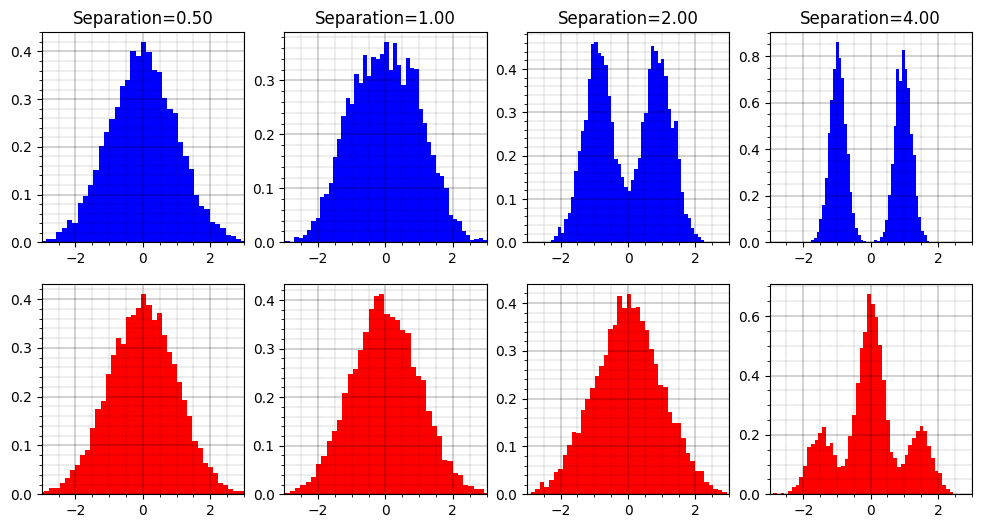

In [43]:
#plot the distributions for differen seprations and N=10000
bins_num=50
Num_points=10000
fig,axs=plt.subplots(2,4,figsize=(12,6))
# define function to plot the histogram
def plot_hist(distr,axs,color,bins,title=''):
  axs.hist(distr,bins=bins,density=True,color=color)
  axs.set_xlim([-3,3])
  axs.minorticks_on()
  axs.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
  axs.grid(which='major', linestyle='-', linewidth='0.25', color='black')
  axs.set_title(title)
#double-peak
for i in range(4):
    separation=2**((i-1))
    plot_hist(double_norm(Num_points,separation),axs[0,i],color='b',bins=bins_num,title='Separation='+f"{separation:.2f}")

#triple-peak
for i in range(4):
    separation=2**((i-1))
    plot_hist(triple_norm(Num_points,separation),axs[1,i],color='r',bins=bins_num)




Let's compare these distributions using  Anderson-Darling k-sample significance level, for each separation parameter.

In [55]:
#Calculate Anderson-Darling k-sample significance level for the above distributions
for i in range(4):
    separation=2**((i-1))
    x=double_norm(10000,separation)
    y=triple_norm(10000,separation)
    res = stats.anderson_ksamp([x,y])
    print("separation=",separation,"Significance level=",res.significance_level)

separation= 0.5 Significance level= 0.25
separation= 1 Significance level= 0.001
separation= 2 Significance level= 0.001
separation= 4 Significance level= 0.001


<ipython-input-55-e73916f5c0eb>:6: UserWarning: p-value capped: true value larger than 0.25
  res = stats.anderson_ksamp([x,y])
<ipython-input-55-e73916f5c0eb>:6: UserWarning: p-value floored: true value smaller than 0.001
  res = stats.anderson_ksamp([x,y])


Now, lets create heatmaps by creating more sampling distribution. We will change the number of points in each sample from 100 to 100,000 using the logariphim scale. We will vary the separation parameter from 1 to about 3.5 using the linear scale. The value for the heatmap will be the Anderson-Darling k-sample significance level. We will see that as the number of points in the samples increases, the significance level becomes more sensitive to small changes in the distribution parameters.

In [8]:
#prepare eatures for the heatmap
#number of values for the distribution sizes
N_points=30

#number of values for the peak separations
N_sep=50

#create lists contaning the number of points and sepration parameters
N=[int(10**(i//10+2)*(i%10+1)) for i in range(N_points)]
sep=[0.1+0.05*j for j in range(N_sep)]

#create lists to use as axis labels
Ns=["%d" % x for x in N]
seps=["%.1f" % x for x in sep]
#this is where we skip some labels
for i in range(N_sep):
    if i%5!=0:
        seps[i]=''

for i in range(N_points):
    if i%2!=0:
        Ns[i]=''


In [9]:
#create heatmap data usiuing Anderson-Darling k-sample significance level
data=np.zeros([N_sep,N_points])

for i in range(N_sep):
    for j in range(N_points):

        x=list(double_norm(N[j],sep[i]))
        y=list(triple_norm(N[j],sep[i]))
        res = stats.anderson_ksamp([x,y])
        data[i,j]=res.significance_level



<ipython-input-9-96335bdbe888>:9: UserWarning: p-value capped: true value larger than 0.25
  res = stats.anderson_ksamp([x,y])
<ipython-input-9-96335bdbe888>:9: UserWarning: p-value floored: true value smaller than 0.001
  res = stats.anderson_ksamp([x,y])


Text(0.5, 1.0, 'Anderson-Darling k-sample significance level')

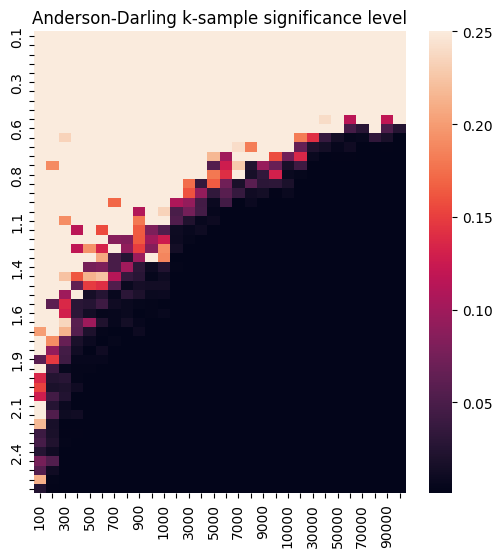

In [46]:
#plot heatmap
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title("Anderson-Darling k-sample significance level")



To consider the likeness of two distributions using the histograms, we will use the Pearson correlation coefficient:
$distr\_likeness(X,Y)=\rho(H_X,H_Y)$

where $H_X$ and $H_Y$ are corresponding histogram values for two samples, taken at the same bin locations and widths.
The number of bins is defined as

$bins=max(20,n/50)$

The histograms are normalized (divided by the total amount of points). We take into account that the samples are normalized, so the bins are distributed in the range from $(-k\sigma,k\sigma)$ with the default value $k=3$.




In [47]:
#define distribution likeness to compare histograms
#sigma defines the speread of the histograms, taken into coparison
# by default, the data withing about  3 standard deviations are considered
def distr_likeness(x,y,sigma=3):
    #find minumum size for the distributions
    M=min(x.size,y.size)
    #define number of bins
    MM=max(20,int(M/50))
    #define bins positions
    bins=[sigma*i/MM for i in range(-MM,MM)]
    #bins=50
    xx,bins=np.histogram(x,bins=bins,density=True)
    yy,bins=np.histogram(y,bins=bins,density=True)
    #yy=hi1[0]#-hi1[0].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
    return (xx,yy,r_value)



We again plot a heatmap using the new sample generated the previosly given lists for the number of points and separation values.

Text(0.5, 1.0, 'Pearson correlation for two histograms')

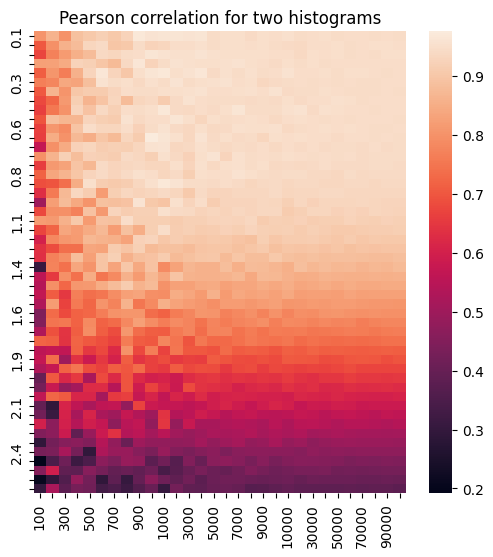

In [48]:
#plot heatmap data by comparing two histograms
for i in range(N_sep):
    for j in range(N_points):

        x=(double_norm(N[j],sep[i]))
        y=(triple_norm(N[j],sep[i]))
        _,_,res = distr_likeness(x,y,sigma=3)
        data[i,j]=res
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title("Pearson correlation for two histograms")

Another way to compare two distributions, is to use quantile-quantile plot. Before that, lets consider an example of two double_peak and triple-peak distributions where $n$=100, $separation$=3, and the nuber of quantiles are 20.
We cam also calculate the Pearson correletion coefficient and see that is is very close to 1, even if there is strong non-linear behavior of the *QQ*-plot.

Pearson correlation coefficient= 0.9762625156339575


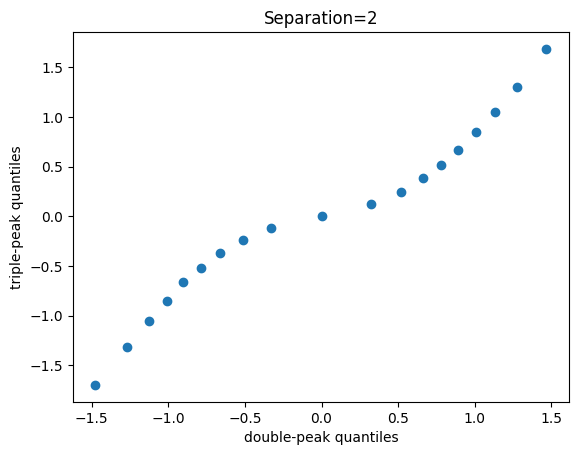

In [49]:
q=[(i+1)*0.05 for i in range(19)]
x=(double_norm(10000,2))
y=(triple_norm(10000,2))
xx=np.quantile(x,q)
yy=np.quantile(y,q)
plt.scatter(xx,yy)
plt.xlabel('double-peak quantiles')
plt.ylabel('triple-peak quantiles')
plt.title("Separation=2")
#lets calculate the Pearson correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
print("Pearson correlation coefficient=",r_value)

To better quantify the non-linear effects, lets consider the following parameter for the likeness using quantile-quantile plot:
$qq\_likeness={\frac{p_1^2}{p_1^2+p_2^2+p_3^2}}$

where $p_1$, $p_2$, and $p_3$ are regression coefficients for the cubic regression:

$qq\_plot(x)\sim p_0+p_1x+p_2x^2+p_3x^3$

Also, lets assign  weights for the polinomial regressionso the tails will be given less importance:

$weights\sim q(1-q)$

where $q$ is the quantile in the range (0,1).


In [50]:
#define likness function for quantile-quantile plots
#q is the number of quantiles to consider
#returns quantiles and the likeness parameter
def qq_likeness(x,y,q=20):
    qq=np.array([(i+1)*1/q for i in range(q-1)])
    xx=np.quantile(x,qq)
    yy=np.quantile(y,qq)
    coef=np.polyfit(xx,yy,3,w=qq*(1-qq))
    r=(coef[2]**2/(coef[0]**2+coef[1]**2+coef[2]**2))

    return xx,yy,r

Now, lets make another heatmap to compare the distrubutions using the $qq\_likeness$ parameter.

Text(0.5, 1.0, ' QQ-likeness for quantile-quantile plot')

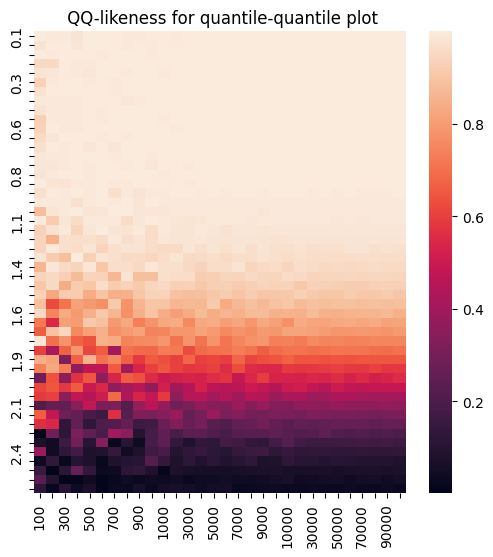

In [51]:
for i in range(N_sep):
    for j in range(N_points):

        x=(double_norm(N[j],sep[i]))
        y=(triple_norm(N[j],sep[i]))
        _,_,res=qq_likeness(x,y)
        data[i,j]=res
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title(" QQ-likeness for quantile-quantile plot")

Let's see how it will work with skewed distributions, that we will make from uneven double-peaked distributions:

 $right\_skewed\sim \mathcal{N}_{3n/4}(-dx,1)+\mathcal{N}_{n/4}(dx,1)$

  $left\_skewed\sim \mathcal{N}_{n/4}(-dx,1)+\mathcal{N}_{3n/4}(dx,1)$

In [52]:
#define distribution functions
#N is the number of points
#dx is the peak sepration before normalization
#for the left-skewed:
def left_norm(N=100,dx=1):
    n=int(N/4)
    x=np.concatenate((np.random.normal(dx, 1,N-n),np.random.normal(-dx, 1,n),),axis=0)
    return (x-x.mean())/x.std()
def right_norm(N=100,dx=1):
    n=int(N/4)
    x=np.concatenate((np.random.normal(dx, 1,n),np.random.normal(-dx, 1,N-n),),axis=0)
    return (x-x.mean())/x.std()

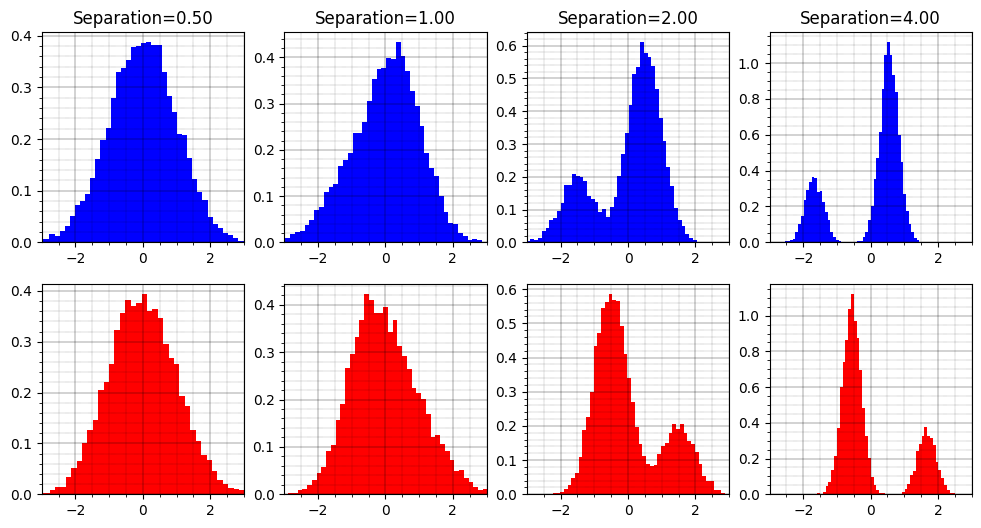

In [53]:
#plot the distributions for differen seprations and N=1000
Num_points=10000
bins_num=50
fig,axs=plt.subplots(2,4,figsize=(12,6))
#left_skewed
for i in range(4):
    separation=2**((i-1))
    plot_hist(left_norm(Num_points,separation),axs[0,i],color='b',bins=bins_num,title='Separation='+f"{separation:.2f}")
#right_skewed
for i in range(4):
    separation=2**((i-1))
    plot_hist(right_norm(Num_points,separation),axs[1,i],color='r',bins=bins_num)


Text(0.5, 1.0, ' QQ-likeness for quantile-quantile plot')

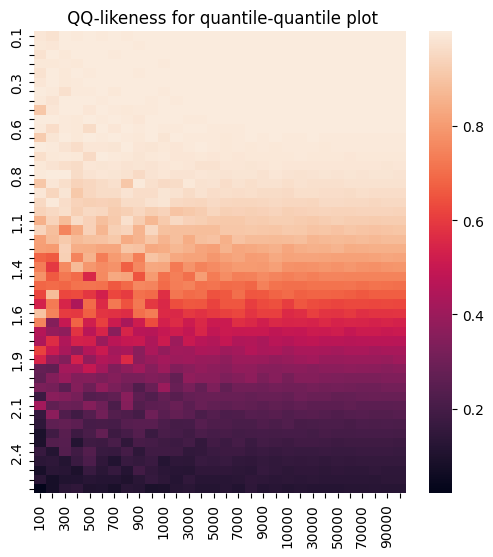

In [54]:
for i in range(N_sep):
    for j in range(N_points):

        x=(left_norm(N[j],sep[i]))
        y=(right_norm(N[j],sep[i]))
        _,_,res=qq_likeness(x,y)
        data[i,j]=res
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title(" QQ-likeness for quantile-quantile plot")